# Лабораторная работа №4

* [Загрузка датасета](#1)
* [Разбиение данных](#5)
* [Создание и обучение сети](#2)
* [Прогнозирование данных](#3)
* [Выводы](#4)

## Загрузка датасета <a id='1'></a>

Для начала работы необходимо загрузить исходный набор данных в датафрейм `Pandas`

In [1]:
import pandas as pd

read_csv = pd.read_csv('data.csv', sep=';')
df = pd.DataFrame(read_csv)

Затем посмотрим основную информацию о полученном наборе данных при помощи команды `df.info()` 

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Year    60 non-null     int64 
 1   Month   60 non-null     int64 
 2   Time    60 non-null     int64 
 3   Data    60 non-null     object
dtypes: int64(3), object(1)
memory usage: 2.0+ KB


Видно, что основной столбец с данными имеет неверный тип данных. Чтобы избавиться от данной проблемы, необходимо посмотреть, а в каком формате хранятся данные в этом столбце при помощи команды `df.head(5)`

In [3]:
df.head(5)

,Year,Month,Time,Data
0,1999,1,1,"82,46"
1,1999,2,2,"73,66"
2,1999,3,3,"69,43"
3,1999,4,4,"70,30"
4,1999,5,5,"62,11"


Теперь видно, что данные должны иметь дробный тип данных, однако запятая, стоящая между целой и дробной частями мешает преобразовать данные к типу *float*. \
Поэтому заменим все запятые на символ точки, а затем изменим тип данных исходного столбца.

In [4]:
df['Data'] = df["Data"].str.replace(',', '.')
df['Data'] = df['Data'].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    60 non-null     int64  
 1   Month   60 non-null     int64  
 2   Time    60 non-null     int64  
 3   Data    60 non-null     float64
dtypes: float64(1), int64(3)
memory usage: 2.0 KB


После выполнения данных преобразований видно, что каждый столбец имеет верный тип данных.\
Теперь можно приступить к разбиению данных на тренировочную и тестовую выборки.

## Разбиение данных <a id='5'></a>

В начале необходимо посмотреть на исходный набор данных, т.е. как выглядят данные, заданные по варианту

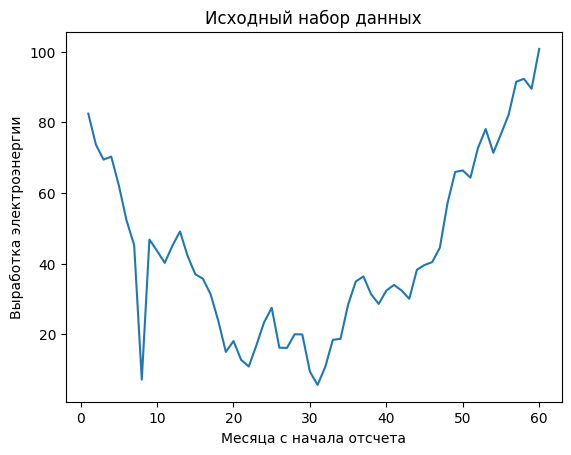

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(df['Time'], df['Data'])
plt.title('Исходный набор данных')
plt.xlabel('Месяца с начала отсчета')
plt.ylabel('Выработка электроэнергии')
plt.show()

Затем необходимо реализовать функцию тестовой выборки, а также создать тренировочные выборки. Данные в тренировочной выборке выглядят следующим образом:
* Правило для `x_train`: На *i*-ом месте в массиве стоит *i*-ое число из столбцов: `df["Data"], df["Year"], df["Month"]`. Массив заполняется с первого до предпоследнего значения;
* Правило для `y_train`: На *i*-ом месте в массиве стоит *i+1*-ое число из столбца `df["Data"]`. Массив заполняется со второго до последнего;

In [57]:
import numpy as np
def split_data(data, time_to: int):
    max_id = len(data) - time_to
    x_test = data[['Year', 'Month','Data']].values[max_id-1:-1].reshape(-1,3)
    y_test = data['Data'].values[max_id:].reshape(-1,1)
    return x_test, y_test

x_train = df[['Year', 'Month','Data']].values[:-1].reshape(-1,3)
y_train = df['Data'].values[1:].reshape(-1,1)
print(f'Размер тренировочной выборки X: {x_train.shape}\nРазмер тренировочной выборки Y: {y_train.shape}')

Размер тренировочной выборки X: (59, 3)
Размер тренировочной выборки Y: (59, 1)


Далее, поскольку в качестве функции активации используется *sigmoid*, то перед тем, как обучать нейронную сеть необходимо нормализовать данные. Для этого была создана функция `normalizer`.

In [58]:
def normalizer(arr, anti = False):
    maxs = np.max(df['Data'])
    mins = np.min(df['Data'])
    if not anti:
        arr = (arr - mins) / (maxs - mins)
    else:
        arr = arr*(maxs - mins) + mins
    return arr

x_train_norm = normalizer(x_train)
y_train_norm = normalizer(y_train)

print(f'Максимальное значение нормализованных данных X: {np.max(x_train_norm):.3}\nСреднее значение нормализованных данных X: {np.average(x_train_norm):.3}')

Максимальное значение нормализованных данных X: 21.0
Среднее значение нормализованных данных X: 7.12


## Создание и обучение сети <a id='2'></a>

После этапа создания обучающих данных логическим продолжением является создание модели нейронной сети. Ниже представлена структура нейронной сети.

In [59]:
from keras import models, layers
def create_model():
    model = models.Sequential()
    model.add(layers.Conv1D(32, 3, activation='sigmoid', input_shape=(None, 3), padding='same'))
    model.add(layers.MaxPooling1D(1))
    model.add(layers.Conv1D(50, 5, activation='sigmoid', padding='same'))
    model.add(layers.MaxPooling1D(1))
    model.add(layers.Dense(64, activation='sigmoid'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.summary()
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
    return model

Затем скомпилируем созданную модель и обучим её на созданных ранее тренировочных данных.

In [60]:
model = create_model()
model.fit(np.array([x_train_norm]), np.array([y_train_norm]), epochs=200)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_14 (Conv1D)          (None, None, 32)          320       
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, None, 32)         0         
 g1D)                                                            
                                                                 
 conv1d_15 (Conv1D)          (None, None, 50)          8050      
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, None, 50)         0         
 g1D)                                                            
                                                                 
 dense_14 (Dense)            (None, None, 64)          3264      
                                                                 
 dense_15 (Dense)            (None, None, 1)          

Ради спортивного интереса, попробуем получить предсказания от модели, обученной на всем множестве данных, и выведем полученный график. Как видно из графика, спрогнозированные значения производят интерполяцию исходных значений.

1/1 [==============================] - 0s 25ms/step


Text(0.5, 1.0, 'Сравнение данных')

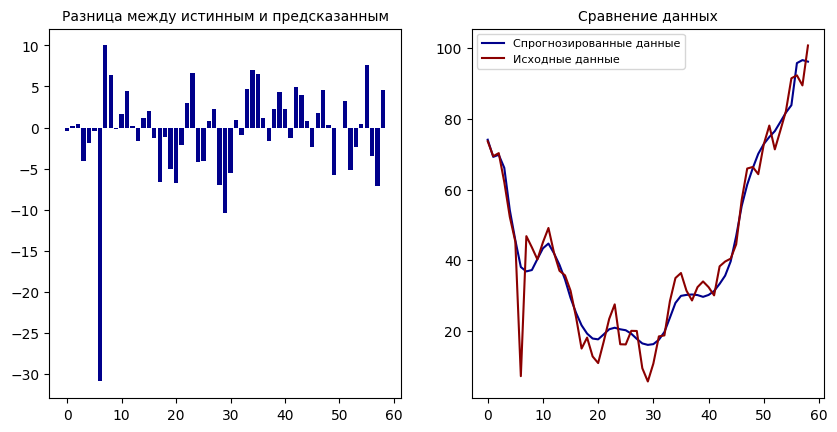

In [113]:
x_test, y_test = split_data(df, 59)
x_test_norm = normalizer(x_test)
predictions = model.predict(np.array([x_test_norm]))
not_norm = normalizer(predictions[0], anti=True)
nums = [i[0] for i in not_norm]
nums_test = [i[0] for i in y_test]
diff = [nums_test[i] - nums[i]  for i in range(len(nums))]
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(10)
ax[0].bar(range(len(diff)), diff, color='darkblue')
ax[0].set_title('Разница между истинным и предсказанным', fontsize=10)
ax[1].plot(nums, color='darkblue', label='Спрогнозированные данные')
ax[1].plot(nums_test, color='darkred', label='Исходные данные')
ax[1].legend(fontsize=8)
ax[1].set_title('Сравнение данных', fontsize=10)

## Прогнозирование данных <a id='3'></a>

Далее необходимо получить прогнозы от обученной модели. Для этого необходимо создать функцию, благодаря которой будет происходить получение предсказание. Данная функция не только получает предсказания от модели, но и создает модель и обучает её на данных, в зависимости от периода прогноза.

In [109]:
def pred(time):
    # Создание тренировочных данных
    x_train = df[['Year', 'Month','Data']].values[:-time].reshape(-1,3)
    y_train = df['Data'].values[:-time].reshape(-1,1)
    x_train_norm = normalizer(x_train)
    y_train_norm = normalizer(y_train)
    # Создание и обучение модели
    model = create_model()
    model.fit(np.array([x_train_norm]), np.array([y_train_norm]), epochs=200)
    # Создание тестовых данных
    x_test, y_test = split_data(df, time)
    x_test_norm = normalizer(x_test)
    print(f'Размер тестовой выборки: {x_test.shape}')
    print(f'Значения тестовой выборки:\n{x_test}')
    # Создание предсказаний
    predictions = model.predict(np.array([x_test_norm]))
    not_norm = normalizer(predictions[0], anti=True)
    print(f'Полученные значения:\n{not_norm}')
    print(f'Истинные значения\n{y_test}')
    # Получение числовых значений
    nums = [i[0] for i in not_norm]
    nums_test = [i[0] for i in y_test]
    diff = [nums_test[i] - nums[i]  for i in range(len(nums))]
    fig, ax = plt.subplots(1, 2)
    fig.set_figwidth(10)
    if len(nums) > 1:
        ax[1].plot(nums, color='darkblue', label='Спрогнозированные данные')
        ax[1].plot(nums_test, color='darkred', label='Исходные данные')
        ax[1].legend(fontsize=8)
        ax[1].set_title('Сравнение данных', fontsize=10)
    ax[0].bar(range(len(diff)), diff, color='darkblue')
    ax[0].set_title('Разница между истинным и предсказанным', fontsize=10)

После создание такой функции, необходимо выполнить прогнозирование временного ряда на 3 периода. Сперва получим предсказания на краткосрочный период (на один период вперед).

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_68 (Conv1D)          (None, None, 32)          320       
                                                                 
 max_pooling1d_68 (MaxPoolin  (None, None, 32)         0         
 g1D)                                                            
                                                                 
 conv1d_69 (Conv1D)          (None, None, 50)          8050      
                                                                 
 max_pooling1d_69 (MaxPoolin  (None, None, 50)         0         
 g1D)                                                            
                                                                 
 dense_68 (Dense)            (None, None, 64)          3264      
                                                                 
 dense_69 (Dense)            (None, None, 1)         

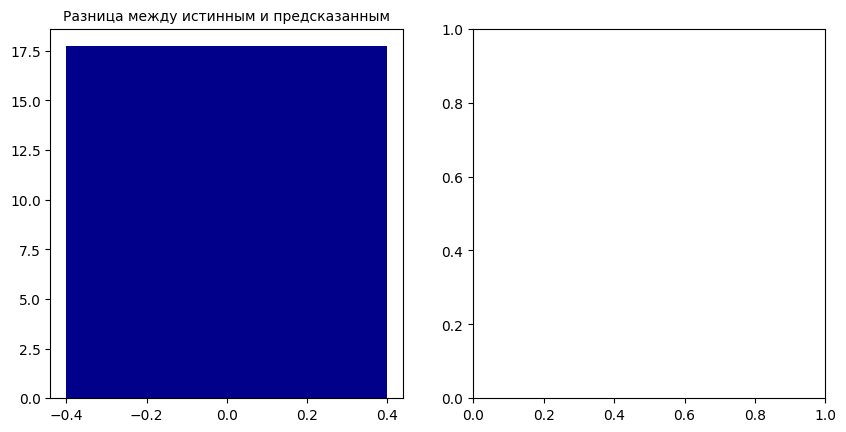

In [110]:
pred(1)

Далее получим предсказания на среднесрочный период (на полгода вперед):

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_70 (Conv1D)          (None, None, 32)          320       
                                                                 
 max_pooling1d_70 (MaxPoolin  (None, None, 32)         0         
 g1D)                                                            
                                                                 
 conv1d_71 (Conv1D)          (None, None, 50)          8050      
                                                                 
 max_pooling1d_71 (MaxPoolin  (None, None, 50)         0         
 g1D)                                                            
                                                                 
 dense_70 (Dense)            (None, None, 64)          3264      
                                                                 
 dense_71 (Dense)            (None, None, 1)         

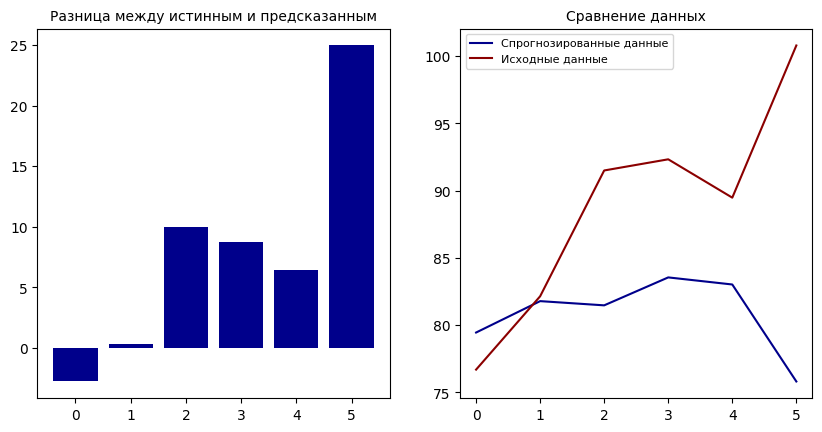

In [111]:
pred(6)

И наконец, получим предсказания на долгосрочный период (на год вперед)

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_72 (Conv1D)          (None, None, 32)          320       
                                                                 
 max_pooling1d_72 (MaxPoolin  (None, None, 32)         0         
 g1D)                                                            
                                                                 
 conv1d_73 (Conv1D)          (None, None, 50)          8050      
                                                                 
 max_pooling1d_73 (MaxPoolin  (None, None, 50)         0         
 g1D)                                                            
                                                                 
 dense_72 (Dense)            (None, None, 64)          3264      
                                                                 
 dense_73 (Dense)            (None, None, 1)         

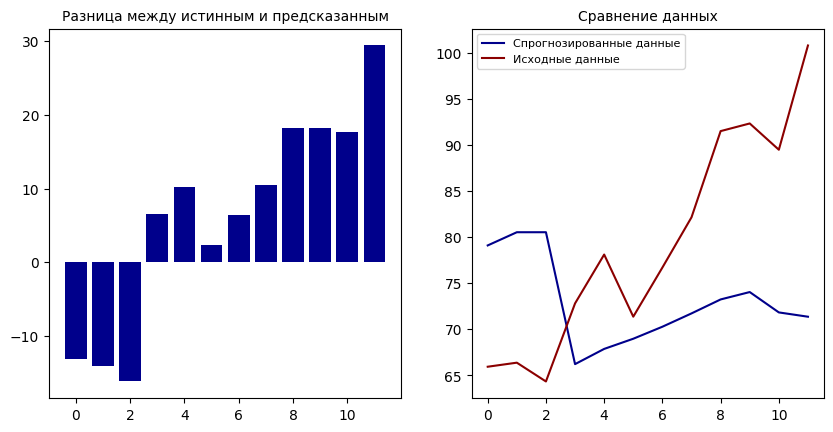

In [112]:
pred(12)

## Выводы <a id='4'></a>

В данной лабораторной была реализована сверточная нейронная сеть для прогнозирования временного ряда. Прогнозирование строилось таким образом, что на вход подаётся значение текущего года, месяца и числовое значение, а на выходе получается предсказанное значение на следующий месяц. Можно отметить, что чем дальше происходит процесс прогнозирования, тем выше становиться оценка прогноза. Также можно отметить, что если обучить нейронную сеть на все объеме данных, а затем запустить процесс получения предсказаний, то модель будет выполнять интерполяцию исходных значений.